# Procesamiento de archivos .sig

Este notebook contiene código y documentación relacionada con el procesamiento y guardado de firmas espectrales en formato .sig que obtiene el espectrorradiómetro SVC HR-1024i.

Fecha: 16 de julio de 2023

mail: taveiragerman@gmail.com

---

En este notebook, se realiza el análisis de firmas utilizando datos de campo y se generan visualizaciones y exportaciones de los resultados. El código y la documentación se presentan en celdas separadas para facilitar la comprensión y el seguimiento del proceso.

A continuación, se importarán las bibliotecas necesarias y se definirán las variables y funciones iniciales requeridas para el análisis. Luego, se procederá con la carga de datos y el procesamiento de las firmas.

## 0. Cargar paquetes requeridos

En el archivo de funciones.py requiere:

        - import pandas as pd  # Importa la biblioteca pandas para el análisis de datos
        - import numpy as np  # Importa la biblioteca numpy para trabajar con matrices y vectores
        - import matplotlib.pyplot as plt  # Importa la biblioteca matplotlib para graficar datos
        - import os  # Importa la biblioteca os para interactuar con el sistema operativo
        - from datetime import datetime, timedelta  # Importa datetime y timedelta para trabajar con fechas y tiempos
        - import geopandas as gpd # Importa la biblioteca geopandas para trabajar con datos geoespaciales

        [!] Se requiere el módulo xlsxwriter para guardar las firmas en xlsx
        !pip install xlsxwriter 

In [12]:
import pandas as pd  # Importa la biblioteca pandas para abrir csv con datos de campo
from functions import * # Importa las funciones del archivo functions.py. El archivo debe estar en la misma carpeta que la notebook

## 1. Configuración de rutas

En esta celda se configuran los parámetros asosiados a las rutas donde se encuentran:

El código utiliza las siguientes variables:

- `cobertura`: indica la cobertura de la serie.
- `hours_offset`: establece la diferencia de tiempo entre la zona horaria de la señal SIG y la zona horaria local.

- `path_out`: especifica la carpeta de salida para el procesamiento.
- `path_sig`: indica la ruta donde se encuentran las carpetas que contienen los archivos .sig.
- `path_tabla_zonas`: es la ruta del archivo CSV que contiene los datos ambientales recogidos en campo, como temperatura, humedad, LAI, etc.
- `path_tabla_amb`: es la ruta del archivo CSV que contiene la fecha, número de firma, zona, nombre de la zona y distancia de cada dato.

Asegúrate de ajustar estas variables según tus necesidades antes de ejecutar el código.


In [13]:
cobertura = 'cebada'  # Cobertura de la serie
hours_offset = -19  # Se define la diferencia de tiempo entre la zona horaria de la señal SIG y la zona horaria local

path_out = './output/'  # Carpeta de salida del procesamiento
path_sig = './data/2022_cebada/sig/'  # Ruta donde se ubican las carpetas con los .sig
path_tabla_zonas = './data/2022_cebada/tabla_campo_2022_zonas.csv'  # Tabla con datos ambientales recogidos en campo (T,HS,LAI,etc)
path_tabla_amb = './data/2022_cebada/tabla_campo_2022_amb.csv'  # Tabla con fecha, n_firma, zona, nombre_zona y distancia de cada dato

## 2. Abrir csv con datos de zonas y distancias

Se crea una nueva columna llamada 'id_date' en el DataFrame 'tabla_campo', la cual se crea a partir de la columna 'fecha'.
Primero, se convierte la columna 'fecha' a un objeto datetime usando el formato 'dd/mm/yyyy'.
Luego, se convierte el objeto datetime a una cadena con formato 'yyyymmdd' y se guarda en la columna 'id_date'.



In [14]:
# Carga un archivo CSV en un DataFrame usando pandas
tabla_campo = pd.read_csv(path_tabla_zonas)  
tabla_campo['id_date'] = pd.to_datetime(tabla_campo['fecha'], format='%d/%m/%Y').dt.strftime('%Y%m%d')

tabla_campo.head(3)

,fecha,n_firma,zona,nombre_zona,distancia,id_date
0,19/8/2022,1,1,bajo,1,20220819
1,19/8/2022,2,1,bajo,1,20220819
2,19/8/2022,3,1,bajo,1,20220819


## 3. Lectura de .sig
En este código, se crea una lista de diccionarios llamada `firmas`, donde cada diccionario contiene una firma y sus metadatos. La función `open_sig()` se utiliza para abrir y leer los archivos .sig en la ubicación especificada por `path_sig`, y la función `list_sig()` genera una lista de nombres de archivos .sig en el directorio. Además, se pasa el parámetro `hours_offset` para ajustar la diferencia de tiempo entre la zona horaria de la señal SIG y la zona horaria local.

Después, puedes acceder al dataframe de la primera firma en la lista utilizando la clave `'data'` del primer diccionario: `firmas[0]['data']`. El resultado muestra una parte del dataframe, con las columnas `'radiancia_original'`, `'target_original'`, `'reflectancia'`, `'radiancia'`, y `'target'`. Los valores de `'radiancia_original'`, `'target_original'` y `'reflectancia'` son copiados directamente del archivo .sig, mientras que los valores de `'radiancia'` y `'target'` son los mismos pero escalados.

Recuerda que puedes cambiar el índice `0` en `firmas[0]` para acceder a los dataframes de otras firmas en la lista.

In [15]:
# Se obtiene una lista de diccionarios, cada uno con las firmas y sus metadatos
firmas = open_sig(sig_list= list_sig(path=path_sig), hours_offset=hours_offset)

# Se visualiza parte del df
firmas[0]['data'].head(3)

,longitud_onda,radiancia_original,target_original,radiancia,target,reflectancia
0,338.5,108408.25,996.85,108.40825,0.99685,0.92
1,340.0,115311.50,1045.55,115.31150,1.04555,0.91
2,341.5,116529.96,1019.95,116.52996,1.01995,0.88


## 4. Procesamiento y metadatos

La función procesar_firmas_ind() toma como entrada las firmas, la diferencia horaria (hours_offset), la cobertura y la tabla de datos de zonas tomadas en campo (tabla_campo). Primero, agrupa las firmas por día utilizando la función agrupar_firmas(), que devuelve un diccionario donde cada clave es la fecha del día y las firmas se agrupan en listas dentro de cada fecha.

Luego, se llama a la función agregar_metadatos() para agregar los metadatos a cada firma en base a la tabla de datos de zonas tomadas en campo. Esto incluye agregar información como zona, nombre_zona, distancia, cobertura, id_firma, entre otros. También  convierten las coordenadas GMS a grados decimales en nuevas keys, `'coordenadas_target'` y `'coordenadas_radiancia'` a partir de los metadatos.

Por último, se devuelve el diccionario dic_firmas_por_fecha que contiene las firmas agrupadas por fecha y con los metadatos agregados.



In [16]:
# Las firmas se agrupan por día en un diccionario
# Cada key del diccionario es la fecha del día en el que se tomaron las firmas
# Las firmas dentro de cada fecha se agrupan en lista
# A cada firma se le agregan metadatos en base a la tabla de datos de zonas tomadas en campo

dic_firmas_por_fecha = procesar_firmas_ind(firmas, hours_offset, cobertura, tabla_campo)


## 5. Ploteo de 'data' por día

En este código, se utiliza la función plot_firmas() para visualizar las firmas por día. Se especifica la zona (num_zona) y la distancia (distancia) que deseas plotear.

Asegúrate de que la variable dic_firmas_por_fecha contenga el diccionario con las firmas agrupadas por fecha y con los metadatos agregados, como se obtiene en la función procesar_firmas_ind().

Esta función plot_firmas() se encarga de trazar los gráficos de reflectancias para cada día, correspondiente a la zona y distancia seleccionadas.

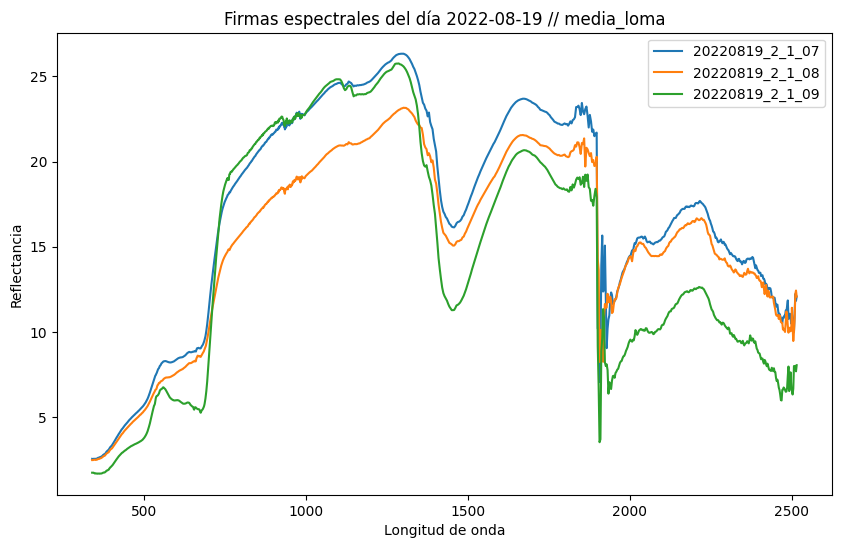

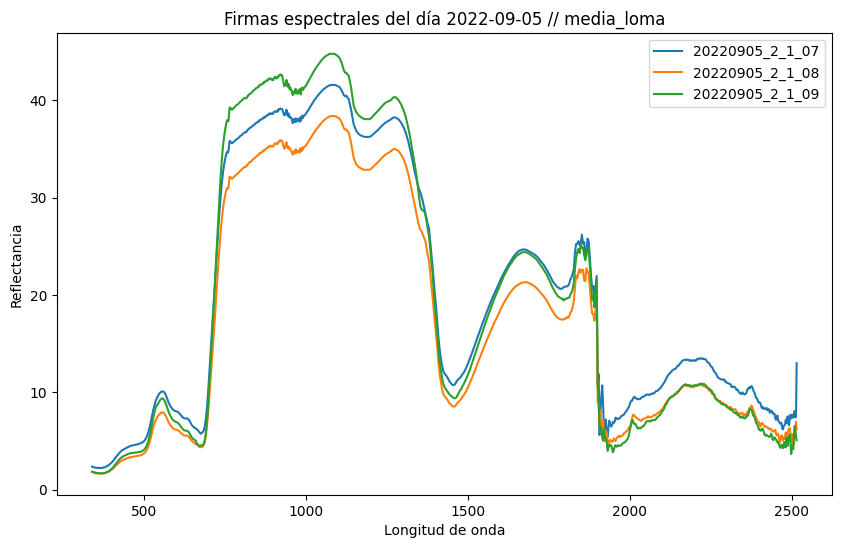

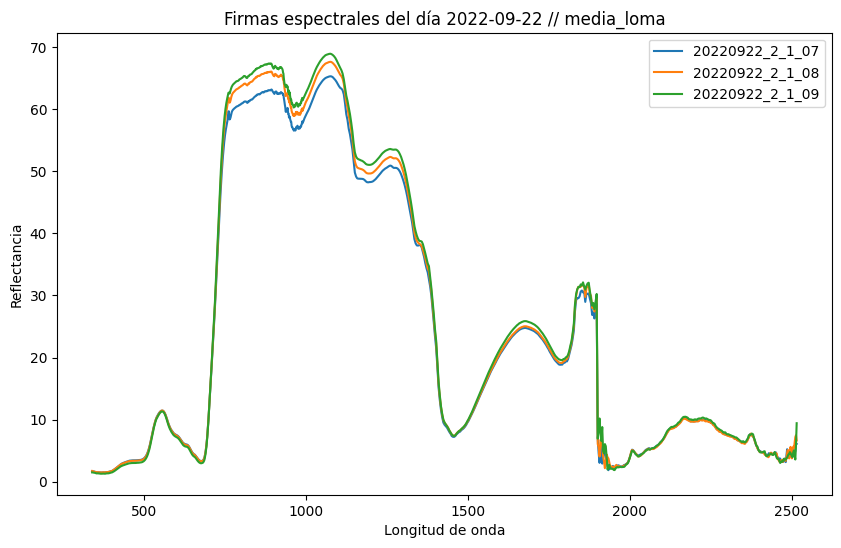

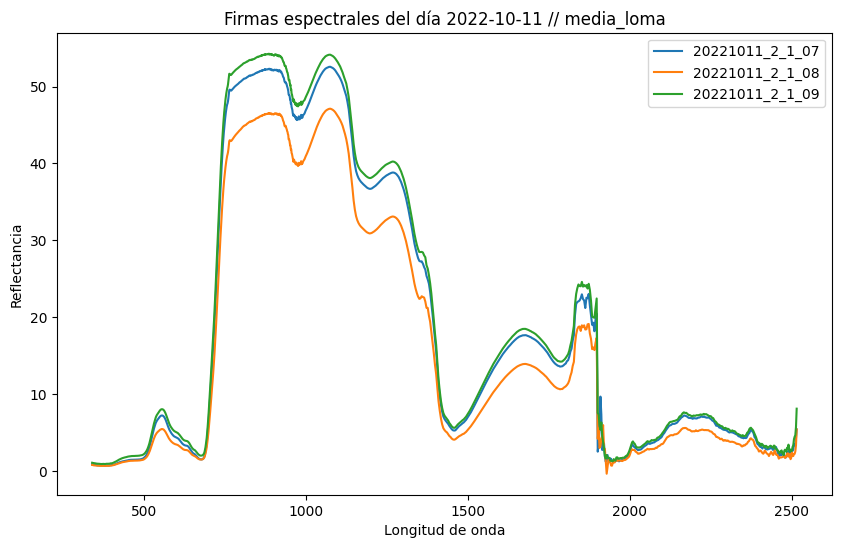

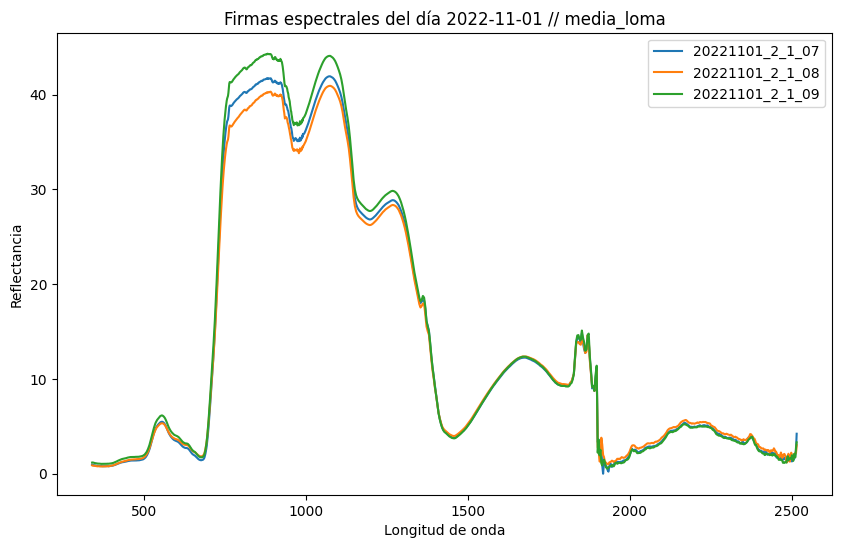

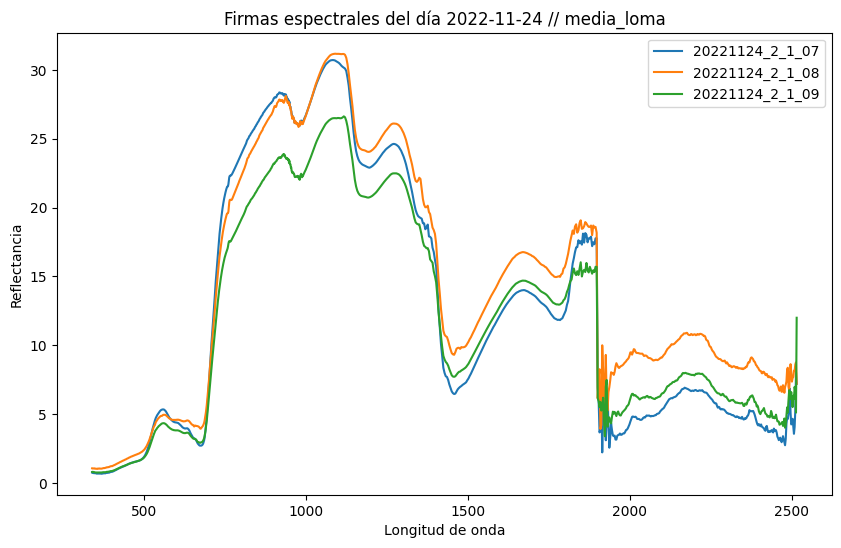

In [17]:
### Se plotea 'data' por día 
## Reflectancias, radiancias y target por del DIA ##

# Seteo las firmas que quiero plotear
num_zona = 2
distancia = 1

plot_firmas_individuales(dic_firmas_por_fecha,
            num_zona,
            distancia)


## 6. Guardar en xlsx las firmas individuales

En este código, se utiliza la función export_xlsx() para guardar todas las firmas individuales en un único archivo XLSX. Se especifica la ruta de salida (path_out), el diccionario de firmas agrupadas por fecha (dic_firmas_por_fecha) y la cobertura (cobertura).

La función export_xlsx() se encarga de crear un archivo XLSX y guardar cada firma en una hoja nueva dentro del archivo. Cada hoja del archivo contendrá los datos de una firma individual.

Asegúrate de tener la biblioteca `xlsxwriter` para que la exportación a Excel se realice correctamente.

In [18]:
# Guardar en xlsx
export_xlsx(path_out= path_out,
            dic_firmas= dic_firmas_por_fecha,
            cobertura= cobertura)

## 7. Promedio de medidas por zona y vínculo con datos ambientales de campo

En esta función, se pasa como entrada el diccionario dic_firmas_por_fecha que contiene las firmas individuales agrupadas por fecha. Además, se proporciona la ruta del archivo de datos ambientales de campo (path_tabla_amb).

La función promediar_firmas_amb() realiza los siguientes pasos:

Utiliza la función promediar_firmas() para calcular el promedio de las firmas por zona. Esto resulta en un nuevo diccionario llamado firmas_prom, que contiene las firmas promediadas por zona.

Utiliza la función vincular_amb_data() para vincular los datos ambientales de campo a las firmas promediadas. Estos datos ambientales, que se encuentran en el archivo especificado por path_tabla_amb, se agregan como metadatos a las firmas promediadas.

Finalmente, se utiliza la función agrupar_firmas_prom() para agrupar las firmas promediadas por fecha en un nuevo diccionario llamado dic_firmas_por_fecha_prom.

La función devuelve dic_firmas_por_fecha_prom, que es el diccionario de firmas promediadas por fecha y vinculadas con los datos ambientales de campo.

In [19]:
# Promedio de medidas por zona y vínculo con datos ambientales de campo
dic_firmas_por_fecha_prom = promediar_firmas_amb(dic_firmas_por_fecha, path_tabla_amb)

## 8. Ploteo de 'data' promedio por día

En este código, se configuran las variables num_zona, distancia, plot y x_lim para especificar los parámetros deseados para el ploteo.

num_zona define la zona que quieres plotear.
distancia especifica la distancia que quieres considerar.
plot indica qué tipo de datos quieres visualizar. Puedes elegir entre 'rad' para las radiancias, 'ref' para las reflectancias o dejarlo por defecto ('rad') para las radiancias.
x_lim establece los límites del eje X para el gráfico. Puedes ajustar los valores numéricos para personalizar los límites.
Luego, se llama a la función plot_firmas() con los parámetros establecidos para trazar las firmas promediadas por fecha según las especificaciones dadas.

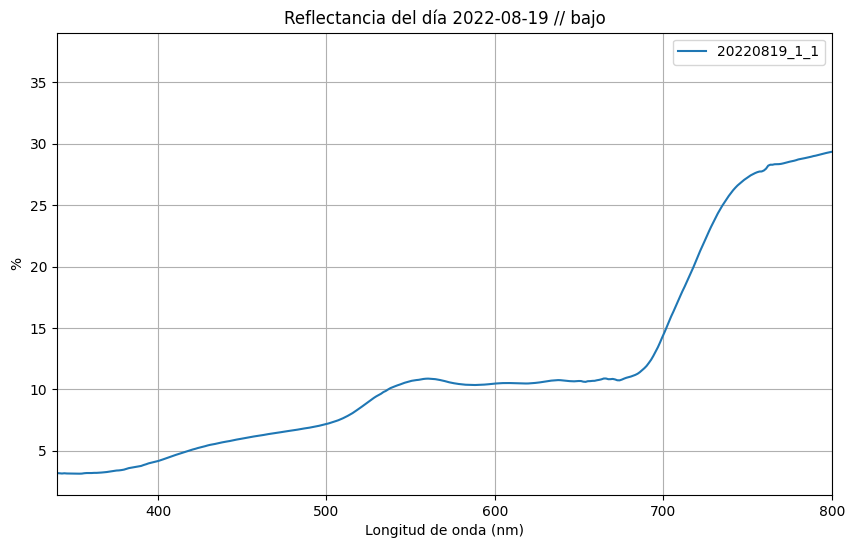

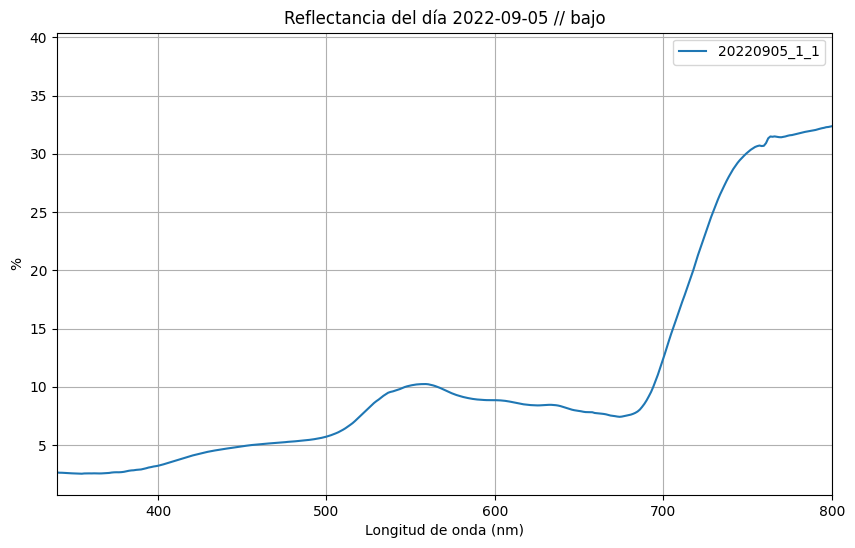

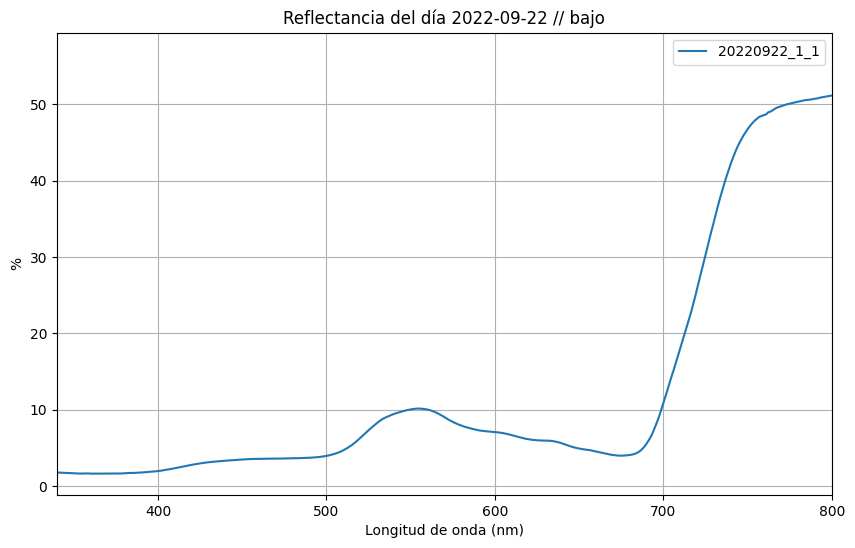

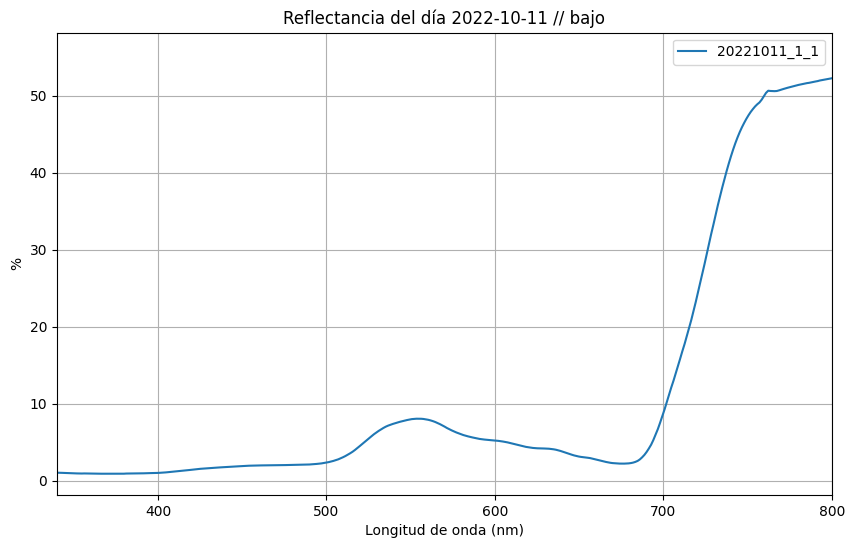

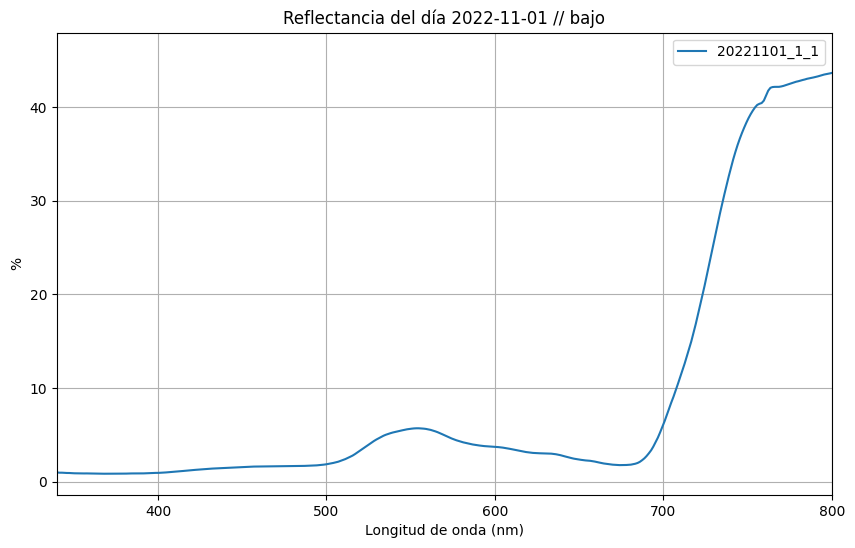

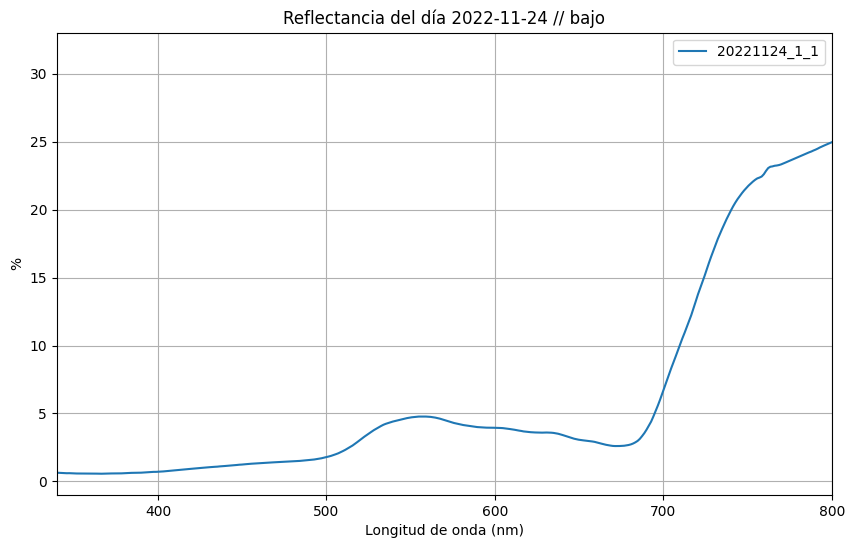

In [20]:
# Seteo las firmas que quiero plotear
num_zona = 1
distancia = 1
plot = 'ref' # rad = radiancias, ref = reflectancias, defoult = radiancias
x_lim = (340,800)

plot_firmas(firmas_fecha= dic_firmas_por_fecha_prom, zona= num_zona, distancia= distancia, plot= plot, x_lim = x_lim)

# #########################

## 9. Guardar en xlsx las firmas individuales

En este código, se utiliza la función export_xlsx() para guardar las firmas promediadas por día en un archivo XLSX. Se especifica la ruta de salida (path_out), el diccionario de firmas promediadas por fecha (dic_firmas_por_fecha_prom), la cobertura (cobertura) y se establece el parámetro prom en True para indicar que son firmas promediadas.

La función export_xlsx() se encarga de crear un archivo XLSX y guardar cada firma promediada en una hoja nueva dentro del archivo. Cada hoja del archivo contendrá los datos de una firma promediada.

Asegúrate de tener la biblioteca `xlsxwriter` para que la exportación a Excel se realice correctamente.


In [10]:
Guardar firmas promediadas en xlsx
export_xlsx(path_out= path_out,
            dic_firmas= dic_firmas_por_fecha_prom,
            cobertura= cobertura,
            prom = True)